In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
import time

import pickle


# Data Exploration

Load data.

In [2]:
file_path = '../raw_data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv'
df_ = pd.read_csv(file_path, parse_dates = ['month'])
df = df_.copy()

Inspect data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157097 entries, 0 to 157096
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                157097 non-null  datetime64[ns]
 1   town                 157097 non-null  object        
 2   flat_type            157097 non-null  object        
 3   block                157097 non-null  object        
 4   street_name          157097 non-null  object        
 5   storey_range         157097 non-null  object        
 6   floor_area_sqm       157097 non-null  float64       
 7   flat_model           157097 non-null  object        
 8   lease_commence_date  157097 non-null  int64         
 9   remaining_lease      157097 non-null  object        
 10  resale_price         157097 non-null  float64       
 11  Address              157097 non-null  object        
 12  Latitude             157097 non-null  float64       
 13  Longitude     

In [4]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272
1,2017-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 01 month,235000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272
2,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,202000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272
3,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,210000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272
4,2018-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,60 years 01 month,220000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272


In [5]:
df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
Address                0
Latitude               0
Longitude              0
nearest_mrt_station    0
distant_nearest_mrt    0
dtype: int64

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,157097.0,97.471023,24.041369,31.000000,82.000000,94.000000,113.000000,2.490000e+02
lease_commence_date,157097.0,1995.686124,13.834514,1966.000000,1985.000000,1996.000000,2008.000000,2.019000e+03
resale_price,157097.0,484351.588099,167452.794849,140000.000000,360000.000000,453000.000000,575000.000000,1.500000e+06
Latitude,157097.0,1.367843,0.042786,1.270380,1.337031,1.368058,1.396299,1.457071e+00
Longitude,157097.0,103.842057,0.070954,103.685228,103.782472,103.846987,103.899542,1.039878e+02
distant_nearest_mrt,157097.0,0.619928,0.391120,0.022420,0.318990,0.540661,0.829747,3.535264e+00


# Data Cleaning/Feature Engineering

We want to convert storey range from string to integer, and also convert remaining lease from string to float.  
Storey range is a range of 3 stories to protect the location of the actual transaction, but we can convert it to an integer as this data can be ordinal.  
Remaining lease (given in years and months) can be considered as continuous data.

In [8]:
df['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '07 TO 09', '04 TO 06', '13 TO 15',
       '28 TO 30', '16 TO 18', '22 TO 24', '19 TO 21', '25 TO 27',
       '34 TO 36', '31 TO 33', '37 TO 39', '40 TO 42', '46 TO 48',
       '43 TO 45', '49 TO 51'], dtype=object)

In [9]:
df['storey'] = df['storey_range'].str[:2].apply(lambda x: int(x))
# df['storey_range_high'] = df['storey_range'].str[-2:].apply(lambda x: int(x))

In [11]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10
1,2017-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 01 month,235000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10
2,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,202000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,1
3,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,210000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,1
4,2018-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,60 years 01 month,220000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,7


Converting remaining lease from string to float

In [12]:
# used for initial conversion but will combine functions later

df['remaining_lease_years'] = df['remaining_lease'].str[:2].apply(lambda x: int(x))
df['remaining_lease_months'] = df['remaining_lease'].str[9:11]
df['remaining_lease_months'].unique()

array(['04', '01', '02', '', '08', '09', '07', '05', '11', '06', '03',
       '10', '0 '], dtype=object)

There are some data in remaining lease that are not consistent with the other rows. The standard ones in the format of XX years YY months (whether XX, YY are 2 digits). However there are a few non-standard data that only show "XX years" or "XX years Y months".

In [13]:
# check for errors
df[df['remaining_lease_months'] == '']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey,remaining_lease_years,remaining_lease_months
5,2018-06-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,60 years,210000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,10,60,
43,2021-08-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,58 years,280000.0,602 ANG MO KIO AVE 5,1.380709,103.835368,YIO CHU KANG MRT STATION,1.070807,1,58,
53,2017-02-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,62 years,312000.0,465 ANG MO KIO AVE 10,1.366201,103.857201,ANG MO KIO MRT STATION,0.946002,7,62,
68,2020-02-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,59 years,246000.0,465 ANG MO KIO AVE 10,1.366201,103.857201,ANG MO KIO MRT STATION,0.946002,4,59,
75,2021-03-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,58 years,298000.0,465 ANG MO KIO AVE 10,1.366201,103.857201,ANG MO KIO MRT STATION,0.946002,7,58,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157087,2023-06-01,SEMBAWANG,4 ROOM,362B,SEMBAWANG CRES,10 TO 12,93.0,Model A,2019,95 years,588000.0,362B SEMBAWANG CRES,1.446593,103.813541,SEMBAWANG MRT STATION,0.773508,10,95,
157089,2023-06-01,SEMBAWANG,4 ROOM,362A,SEMBAWANG CRES,07 TO 09,93.0,Model A,2019,95 years,556888.0,362A SEMBAWANG CRES,1.447195,103.814008,SEMBAWANG MRT STATION,0.702661,7,95,
157090,2023-06-01,SEMBAWANG,4 ROOM,362A,SEMBAWANG CRES,10 TO 12,93.0,Model A,2019,95 years,588000.0,362A SEMBAWANG CRES,1.447195,103.814008,SEMBAWANG MRT STATION,0.702661,10,95,
157091,2023-07-01,SEMBAWANG,4 ROOM,362A,SEMBAWANG CRES,16 TO 18,93.0,Model A,2019,95 years,560000.0,362A SEMBAWANG CRES,1.447195,103.814008,SEMBAWANG MRT STATION,0.702661,16,95,


In [14]:
df['remaining_lease_months'] = df['remaining_lease_months'].apply(lambda x: 0 if x == '0 ' or x =='' else x)
df['remaining_lease_months'] = df['remaining_lease_months'].apply(lambda x: int(x))
print(df['remaining_lease_months'].unique())

df['remaining_lease_years'] = df['remaining_lease_years'] + df['remaining_lease_months'].apply(lambda x: x/12)

[ 4  1  2  0  8  9  7  5 11  6  3 10]


Combining the functions together into 1 lambda function

In [15]:
df['r_lease'] = df['remaining_lease'].apply(lambda x: (int(x[:2])) if x[9:11]== '0 ' or x[9:11] == '' else (int(x[:2]) + int(x[9:11])/12))

In [16]:
# r_lease works as expected (comparing the column with remaining_lease years)
df.sample(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey,remaining_lease_years,remaining_lease_months,r_lease
87283,2023-01-01,BUKIT PANJANG,5 ROOM,541,BT PANJANG RING RD,22 TO 24,121.0,Improved,1999,75 years 05 months,715000.0,541 BT PANJANG RING RD,1.382452,103.763479,SENJA LRT STATION,0.124226,22,75.416667,5,75.416667
66928,2017-04-01,PUNGGOL,4 ROOM,133,EDGEDALE PLAINS,01 TO 03,91.0,Premium Apartment,2003,85 years 07 months,320000.0,133 EDGEDALE PLAINS,1.392832,103.910620,CORAL EDGE LRT STATION,0.246447,1,85.583333,7,85.583333
116091,2020-07-01,TAMPINES,4 ROOM,240,TAMPINES ST 21,04 TO 06,105.0,Model A,1984,63 years 02 months,450000.0,240 TAMPINES ST 21,1.355004,103.947121,TAMPINES MRT STATION,0.292354,4,63.166667,2,63.166667
96738,2020-11-01,HOUGANG,4 ROOM,137,LOR AH SOO,10 TO 12,105.0,Model A,1985,63 years 06 months,390000.0,137 LOR AH SOO,1.349053,103.886640,BARTLEY MRT STATION,1.032676,10,63.500000,6,63.500000
138514,2021-12-01,SENGKANG,4 ROOM,329B,ANCHORVALE ST,04 TO 06,93.0,Model A,2015,92 years 08 months,480000.0,329B ANCHORVALE ST,1.395763,103.889467,FARMWAY LRT STATION,0.157748,4,92.666667,8,92.666667


Quick plot to check relationships between numerical features

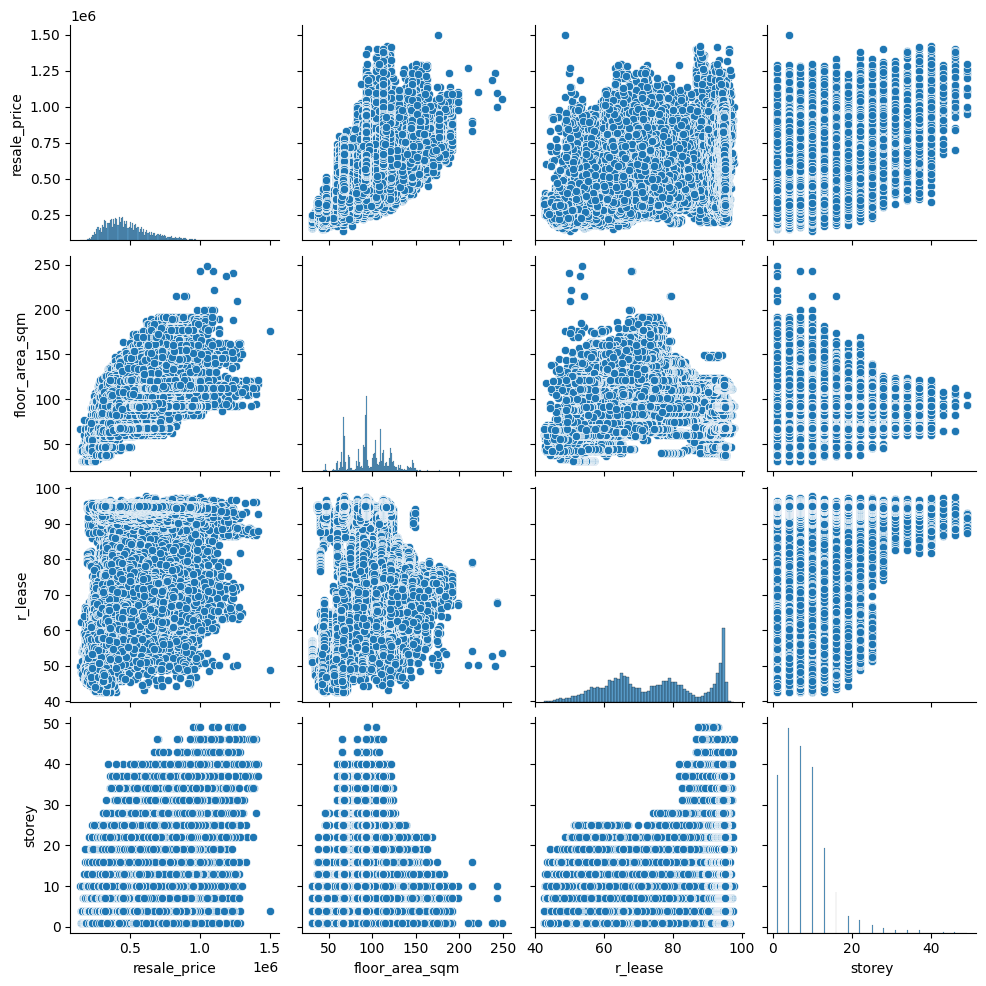

In [17]:
quick_plot_df = df[['resale_price', 'floor_area_sqm', 'r_lease', 'storey']]
sns.pairplot(quick_plot_df)
plt.show();

# Preprocessor (Process)

### One Hot Encode features

In [18]:
df.head(2)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey,remaining_lease_years,remaining_lease_months,r_lease
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10,61.333333,4,61.333333
1,2017-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 01 month,235000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10,61.083333,1,61.083333


Select required features

In [19]:
X = df[['month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model', 'r_lease', 'storey']]
y = df['resale_price']

In [20]:
X.dtypes

month             datetime64[ns]
town                      object
flat_type                 object
floor_area_sqm           float64
flat_model                object
r_lease                  float64
storey                     int64
dtype: object

In [21]:
X.head(2)

,month,town,flat_type,floor_area_sqm,flat_model,r_lease,storey
0,2017-01-01,ANG MO KIO,2 ROOM,44.0,Improved,61.333333,10
1,2017-05-01,ANG MO KIO,2 ROOM,44.0,Improved,61.083333,10


We need to One Hot Encode features that are nominal, which are 'town', 'flat_type', 'flat_model'.

In [22]:
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [24]:
df['flat_type'].unique()

array(['2 ROOM', '3 ROOM', '4 ROOM', 'EXECUTIVE', '5 ROOM', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

In [25]:
df['flat_model'].unique()

array(['Improved', 'New Generation', 'Adjoined flat', 'DBSS', 'Standard',
       'Model A', 'Apartment', 'Simplified', 'Premium Apartment',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Premium Apartment Loft', 'Premium Maisonette',
       '2-room', 'Terrace', 'Multi Generation', 'Improved-Maisonette',
       '3Gen'], dtype=object)

We want to ensure that training set and prediction set will have the same number of features after preprocessing.

In [26]:
town_list = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN']

flat_type_list = ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
       'MULTI-GENERATION']

flat_model_list = ['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
       'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
       'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
       'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
       'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen']

categorical_features_names = [np.array(town_list, dtype=object), 
                              np.array(flat_type_list, dtype=object),
                              np.array(flat_model_list, dtype=object)]

In [27]:
len(categorical_features_names)

3

In [28]:
categorical_ohe = OneHotEncoder(
    categories = categorical_features_names,
    handle_unknown = "ignore",
    sparse = False
)

categorical_features = ['town', 'flat_type', 'flat_model']

# to include in final_preprocessor as...
# final_preprocessor = ColumnTransformer(
#             [
#                 ("categorical", categorical_ohe, categorical_features)
#             ])

### Numerical (Scalars)

Applying normalization to numerical features.  
We have large amounts of data to preprocess (potentially adding more data each month). It would be more computational friendly to fix the values for a min-max scalar.  
  
From the data, we know the following values as the minimum and maximum.  
**Floor Area** - min: 31, max: 249  
**Storey** - min: 1, max: 51  
**Remaining Lease Years** - min: 42.58, max: 99  
  
But in theory, the minimum floor area would be 0, and the lowest remaining lease years will eventually be 0. Knowing the housing situation in Singapore, it is also unlikely that houses with larger floor area will be built compared to the current maximum, and also unlikely for houses to be built much taller. The lease length is unlikely to change unless there is a change of policy as well.  
  
Hence, we can set the minimum values as such, and take the liberty to slightly increase and set the maximum values.  
**Floor Area** - min: 0, max: 260  
**Storey** - min: 1, max: 55  
**Remaining Lease Years** - min: 0, max: 99  

In [29]:
# Floor Area min/max
f_area_min = 0
f_area_max = 260

# Storey min/max
storey_min = 1
storey_max = 55

# Remaining lease years min/max
r_lease_min = 0
r_lease_max = 99

In [30]:
f_area_pipe = FunctionTransformer(lambda p: (p - f_area_min) / (f_area_max - f_area_min))
storey_pipe = FunctionTransformer(lambda p: (p - storey_min) / (storey_max - storey_min))
r_lease_pipe = FunctionTransformer(lambda p: (p - r_lease_min) / (r_lease_max - r_lease_min))

In [31]:
final_preprocessor = ColumnTransformer(
            [
                ("f_area_scalar", f_area_pipe, ["floor_area_sqm"]),
                ("storey_scalar", storey_pipe, ["storey"]),
                ("r_lease_scalar", r_lease_pipe, ["r_lease"]),
                ("categorical", categorical_ohe, categorical_features)
            ],
            n_jobs=-1,
        )

In [32]:
X_transformed = final_preprocessor.fit_transform(X)
print(X_transformed.shape)
print(X_transformed)

(157097, 57)
[[0.16923077 0.16666667 0.61952862 ... 0.         0.         0.        ]
 [0.16923077 0.16666667 0.61700337 ... 0.         0.         0.        ]
 [0.16923077 0.         0.60774411 ... 0.         0.         0.        ]
 ...
 [0.35769231 0.22222222 0.95875421 ... 0.         0.         0.        ]
 [0.35769231 0.11111111 0.95959596 ... 0.         0.         0.        ]
 [0.35384615 0.16666667 0.95875421 ... 0.         0.         0.        ]]


# Preprocessor (Whole Function)

In [33]:
df.head(1)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey,remaining_lease_years,remaining_lease_months,r_lease
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10,61.333333,4,61.333333


The features of the raw data and features of a single row of user-input prediction may be different.  
   
Raw Data Features: month, town, flat_type, block, street_name, storey_range (string dtype), floor_area_sqm, flat_model, lease_commence_date, remaining_lease, *(target) resale_price*  
  
Columns that we are using to as our features in X are:  
**Raw Data Features (removing unused columns)**: month, town, flat_type, storey_range (string dtype), floor_area_sqm, flat_model, remaining_lease
  
We want to reduce error from user input. Month can be automatically set from today's date.  
**User Input Features**: town, flat_type, storey (int), floor_area_sqm, flat_model, remaining lease

In [34]:
# use original raw data to test
df_test = df_.copy()
df_test

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272
1,2017-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 01 month,235000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272
2,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,202000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272
3,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60 years 02 months,210000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272
4,2018-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,60 years 01 month,220000.0,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157092,2023-07-01,SEMBAWANG,4 ROOM,362A,SEMBAWANG CRES,04 TO 06,93.0,Model A,2019,94 years 11 months,550000.0,362A SEMBAWANG CRES,1.447195,103.814008,SEMBAWANG MRT STATION,0.702661
157093,2023-06-01,SEMBAWANG,4 ROOM,366B,SEMBAWANG CRES,10 TO 12,93.0,Model A,2019,94 years 11 months,568000.0,366B SEMBAWANG CRES,1.443922,103.815958,SEMBAWANG MRT STATION,0.729568
157094,2023-07-01,SEMBAWANG,4 ROOM,366B,SEMBAWANG CRES,13 TO 15,93.0,Model A,2019,94 years 11 months,565000.0,366B SEMBAWANG CRES,1.443922,103.815958,SEMBAWANG MRT STATION,0.729568
157095,2023-07-01,HOUGANG,4 ROOM,992B,BUANGKOK LINK,07 TO 09,93.0,Model A,2019,95 years,598000.0,992B BUANGKOK LINK,1.383827,103.881672,TONGKANG LRT STATION,0.768356


In [35]:
def raw_data_process(df: pd.DataFrame):
    '''
    Takes in raw data (in DataFrame),
    returns X (pd.DataFrame), y (pd.Series)
    where X has unused columns removed, 
    and the features are the same as the one generated from user input.
    '''
    X = df.drop(columns = ['resale_price', 'block', 'street_name', 'lease_commence_date'])
    y = df['resale_price']
    
    # X is left with month, town, flat_type, 
    # storey_range (string), floor_area_sqm, flat_model, remaining_lease
    # To get to the same features as user input, we have to process storey_range
    
    X['storey'] = X['storey_range'].apply(lambda x: int(x[:2]))
    X.drop(columns = ['storey_range'], inplace = True)
    
    return X, y

In [36]:
X_tmp, y_tmp = raw_data_process(df_test)
X_tmp.head(1)

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey
0,2017-01-01,ANG MO KIO,2 ROOM,44.0,Improved,61 years 04 months,406 ANG MO KIO AVE 10,1.362005,103.85388,ANG MO KIO MRT STATION,1.004272,10


In [37]:
def preprocessor(X: pd.DataFrame):
    '''
    Takes in DataFrame, returns processed data.
    Transforms a dataset with 7 features into a dataset with 57 features.
    
    Stateless operation.
    '''
    # Convert remaining_lease from the format XX years YY months to a float (years)
    X['r_lease'] = X['remaining_lease'].apply(lambda x: (int(x[:2])) if x[9:11]== '0 ' or x[9:11] == '' else (int(x[:2]) + int(x[9:11])/12))
    X.drop(columns = ['remaining_lease'], inplace = True)
    
    #extract year and month details from month column and drop the month column
    X['sale_year'] = X['month'].dt.year
    X['sale_month'] = X['month'].dt.month
    X['sale_month_sin'] = np.sin(2 * np.pi * X.sale_month/12)
    X['sale_month_cos'] = np.cos(2 * np.pi * X.sale_month/12)
    
    X.drop(columns = ['month','sale_month'], inplace = True)

    def create_preprocessor() -> ColumnTransformer:
        # One hot encoding for categorical features
        town_list = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
        'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
        'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
        'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
        'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
        'TOA PAYOH', 'WOODLANDS', 'YISHUN']

        flat_type_list = ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', '1 ROOM',
            'MULTI-GENERATION']

        flat_model_list = ['Improved', 'New Generation', 'DBSS', 'Standard', 'Apartment',
            'Simplified', 'Model A', 'Premium Apartment', 'Adjoined flat',
            'Model A-Maisonette', 'Maisonette', 'Type S1', 'Type S2',
            'Model A2', 'Terrace', 'Improved-Maisonette', 'Premium Maisonette',
            'Multi Generation', 'Premium Apartment Loft', '2-room', '3Gen']

        categorical_features_names = [np.array(town_list, dtype=object), 
                                    np.array(flat_type_list, dtype=object),
                                    np.array(flat_model_list, dtype=object)]
        
        categorical_ohe = OneHotEncoder(
            categories = categorical_features_names,
            handle_unknown = "ignore",
            sparse = False
            )

        categorical_features = ['town', 'flat_type', 'flat_model']
        
        # Numerical scalars
        
        # Floor Area min/max
        f_area_min = 0
        f_area_max = 260

        # Storey min/max
        storey_min = 1
        storey_max = 55

        # Remaining lease years min/max
        r_lease_min = 0
        r_lease_max = 99
        
        f_area_pipe = FunctionTransformer(lambda p: (p - f_area_min) / (f_area_max - f_area_min))
        storey_pipe = FunctionTransformer(lambda p: (p - storey_min) / (storey_max - storey_min))
        r_lease_pipe = FunctionTransformer(lambda p: (p - r_lease_min) / (r_lease_max - r_lease_min))

        # Combined preprocessor
        final_preprocessor = ColumnTransformer(
                [
                    ("f_area_scalar", f_area_pipe, ["floor_area_sqm"]),
                    ("storey_scalar", storey_pipe, ["storey"]),
                    ("r_lease_scalar", r_lease_pipe, ["r_lease"]),
                    ("categorical", categorical_ohe, categorical_features)
                ],
                n_jobs=-1,
                remainder='passthrough'
            )
        return final_preprocessor
    
    preprocessor = create_preprocessor()
    X_processed = preprocessor.fit_transform(X)
    
    return X_processed

In [38]:
X_tmp

,month,town,flat_type,floor_area_sqm,flat_model,remaining_lease,Address,Latitude,Longitude,nearest_mrt_station,distant_nearest_mrt,storey
0,2017-01-01,ANG MO KIO,2 ROOM,44.0,Improved,61 years 04 months,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,10
1,2017-05-01,ANG MO KIO,2 ROOM,44.0,Improved,61 years 01 month,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,10
2,2018-03-01,ANG MO KIO,2 ROOM,44.0,Improved,60 years 02 months,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,1
3,2018-03-01,ANG MO KIO,2 ROOM,44.0,Improved,60 years 02 months,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,1
4,2018-05-01,ANG MO KIO,2 ROOM,44.0,Improved,60 years 01 month,406 ANG MO KIO AVE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.004272,7
...,...,...,...,...,...,...,...,...,...,...,...,...
157092,2023-07-01,SEMBAWANG,4 ROOM,93.0,Model A,94 years 11 months,362A SEMBAWANG CRES,1.447195,103.814008,SEMBAWANG MRT STATION,0.702661,4
157093,2023-06-01,SEMBAWANG,4 ROOM,93.0,Model A,94 years 11 months,366B SEMBAWANG CRES,1.443922,103.815958,SEMBAWANG MRT STATION,0.729568,10
157094,2023-07-01,SEMBAWANG,4 ROOM,93.0,Model A,94 years 11 months,366B SEMBAWANG CRES,1.443922,103.815958,SEMBAWANG MRT STATION,0.729568,13
157095,2023-07-01,HOUGANG,4 ROOM,93.0,Model A,95 years,992B BUANGKOK LINK,1.383827,103.881672,TONGKANG LRT STATION,0.768356,7


In [39]:
X_tmp2 = preprocessor(X_tmp)


In [40]:
X_tmp2.shape

(157097, 65)

# Model

In [41]:
df2 = df_.copy()

In [59]:
df2

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
157092,2023-07-01,YISHUN,5 ROOM,504B,YISHUN ST 51,04 TO 06,113.0,Improved,2016,91 years 09 months,645000.0
157093,2023-07-01,YISHUN,5 ROOM,613,YISHUN ST 61,07 TO 09,121.0,Improved,1987,62 years 10 months,610000.0
157094,2023-07-01,YISHUN,5 ROOM,713,YISHUN ST 71,04 TO 06,122.0,Improved,1987,63 years 01 month,535000.0
157095,2023-07-01,YISHUN,5 ROOM,758,YISHUN ST 72,04 TO 06,129.0,Improved,1986,62 years 05 months,620000.0


In [42]:
X,y = raw_data_process(df2)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)

In [44]:
X_train_processed = preprocessor(X_train)
X_test_processed = preprocessor(X_test)

In [45]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor()
model_lgbm = lgb.LGBMRegressor()
model_dt = DecisionTreeRegressor()

In [46]:
model_list = [model_lr, model_rf, model_lgbm, model_dt]
model_names = ['model_lr', 'model_rf', 'model_lgbm', 'model_dt']

In [47]:
model_performance = dict()

for model, model_name in zip(model_list, model_names):
    print(model_name)
    starttime = time.time()
    model.fit(X_train_processed, y_train)
    endtime = time.time()
    print(f"fit time = {endtime - starttime}")
    # y_pred = model.predict(X_test_transformed)
    
    starttime = time.time()
    score = model.score(X_test_processed, y_test)
    endtime = time.time()
    print(f"prediction time = {endtime - starttime}")
    print('\n')
    # print(f"model score = {score}")
    
    model_performance[model_name] = score
    
model_performance

model_lr


ValueError: could not convert string to float: '387 TAMPINES ST 32'

In [73]:
# with open('model_lr.pickle', 'wb') as f:
#     pickle.dump(model_lr, f)